# CYBERBULLYING CLASSIFICATION - EQUIPO 4





## DATASET

[Dataset: Cyberbullying Classification](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification/data)

## IMPORTS

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
import plotly.express as px
from textblob import TextBlob

# from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_curve,roc_auc_score,auc
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

## INTRODUCCION

In [4]:
url = "https://raw.githubusercontent.com/noequalindi/1000IA_course/main/cyberbullying_tweets.csv"
df_raw = pd.read_csv(url, sep=',')
df_raw.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [6]:
df_raw.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


In [7]:
categorias_unicas = df_raw.iloc[:, 1].unique()

print("Categorías existentes en la columna cyberbullying_type:")
for categoria in categorias_unicas:
    print(categoria)


Categorías existentes en la columna cyberbullying_type:
not_cyberbullying
gender
religion
other_cyberbullying
age
ethnicity



# RESUMEN
***

1. Título:  
 Cyberbullying Classification

2. Fuente:  

    J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.

3. Información relevante:  

  A medida que el uso de las redes sociales se vuelve cada vez más frecuente en todos los grupos de edad, una gran mayoría de los ciudadanos confía en este medio esencial para la comunicación diaria. La ubicuidad de las redes sociales significa que el ciberacoso puede afectar a cualquiera, en cualquier momento y en cualquier lugar, y el relativo anonimato de Internet hace que estos ataques personales sean más difíciles de detener que el acoso tradicional. El 15 de abril de 2020, UNICEF emitió una advertencia en respuesta al mayor riesgo de ciberacoso durante la pandemia de COVID-19 debido al cierre generalizado de las escuelas, el aumento del tiempo frente a pantallas y la disminución de la interacción social cara a cara. Las estadísticas del ciberacoso son francamente alarmantes: el 36,5% de los estudiantes de secundaria y preparatoria han sentido ciberacoso y el 87% han observado ciberacoso, con efectos que van desde una disminución en el rendimiento académico hasta depresión y pensamientos suicidas. A la luz de todo esto, este conjunto de datos contiene más de 47.000 tuits etiquetados según el tipo de ciberacoso.


4. Instancias: 47692

6. Atributos: 2

7. Información de los atributos:  
  Verificamos que el dataframe posee 47692 registros, sin registros que contengan valores nulos y 2 columnas de las cuales la columna 'cyberbullying_type' sera nuestra variable objetivo categórica no ordinal, este atributo posee 6 clases únicas las cuales son:    

  *   not_cyberbullying
  *   gender
  *   religion
  *   other_cyberbullying
  *   age
  *   ethnicity   

  El atributo restante es de tipo texto por lo que podemos determinar que se trata de un problema de Clasificación. No obstante nos encontramos con registros duplicados ya que como único se identfica un total de 46017 sobre 47692. Verificamos la doocumentacón de kaggle y encontramos esta información: *The data has been balanced in order to contain ~8000 of each class.* por lo que decidimos no eliminar los duplicados.




## ANÁLISIS EXPLORATORIO DE DATOS

### Análisis univariado de la variable objetivo

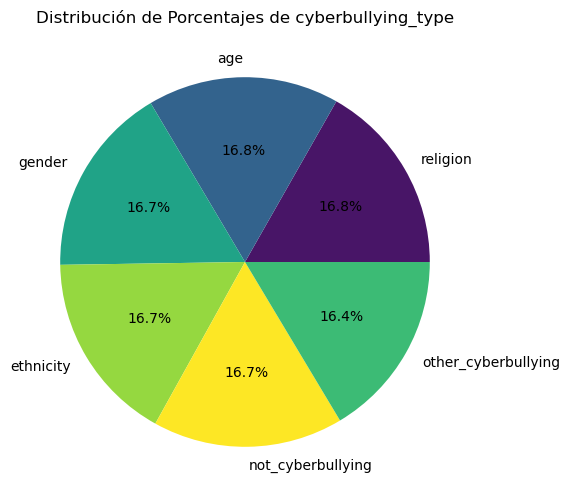

In [8]:
class_counts = df_raw['cyberbullying_type'].value_counts()
colors = ['#481567', '#33638D', '#20A387', '#95D840', '#FDE725', '#3CBB75']
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Distribución de Porcentajes de cyberbullying_type')
plt.show()

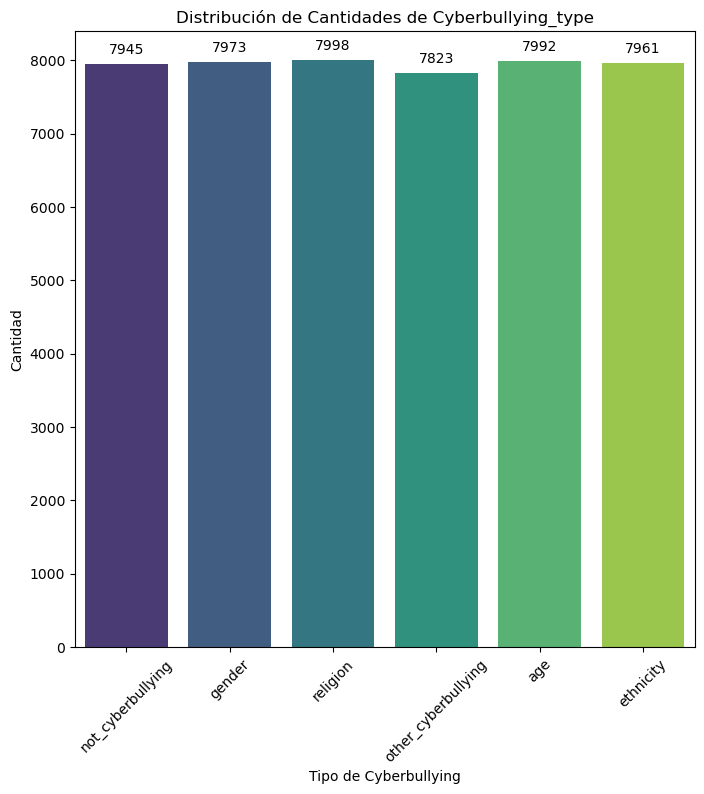

In [9]:
plt.figure(figsize=(8, 8))
ax = sns.countplot(data=df_raw, x='cyberbullying_type', palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Cantidad')
plt.title('Distribución de Cantidades de Cyberbullying_type')
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 100,
        f'{int(p.get_height())}',
        ha='center',
        va='bottom'
    )

plt.show()

### Análisis de estadísticos

In [10]:
df_raw['text_length'] = df_raw['tweet_text'].apply(len)
df_raw

,tweet_text,cyberbullying_type,text_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90


In [31]:
# Función para extraer estadísticas de un tweet
nlp = spacy.load("en_core_web_sm")

# Función para extraer estadísticas de un tweet
def analyze_tweet(text):
    doc = nlp(text)
    num_tokens = len(doc)
    num_words = len([token for token in doc if token.is_alpha])
    num_chars = len(text)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_punctuations = len([token for token in doc if token.is_punct])
    num_nouns = len([token for token in doc if token.pos_ == "NOUN"])
    num_verbs = len([token for token in doc if token.pos_ == "VERB"])
    
    return {
        'num_tokens': num_tokens,
        'num_words': num_words,
        'num_chars': num_chars,
        'num_stopwords': num_stopwords,
        'num_punctuations': num_punctuations,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs
    }

# Aplicar la función a cada tweet en el DataFrame
stats = df_raw['clean_tweet'].apply(analyze_tweet)

# Convertir la lista de diccionarios en un DataFrame
stats_df = pd.DataFrame(list(stats))

# Añadir las estadísticas al DataFrame original
for column in stats_df.columns:
    df_raw[column] = stats_df[column]

# Añadir tokenización y lematización
df_raw['tokens'] = df_raw['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_raw['lemmas'] = df_raw['clean_tweet'].apply(lambda text: [token.lemma_ for token in nlp(text)])

# Función para detectar outliers usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Detectar outliers en las columnas numéricas
outliers_num_tokens = detect_outliers(df_raw, 'num_tokens')
outliers_num_words = detect_outliers(df_raw, 'num_words')
outliers_num_chars = detect_outliers(df_raw, 'num_chars')

print("Outliers en num_tokens:\n", outliers_num_tokens)
print("Outliers en num_words:\n", outliers_num_words)
print("Outliers en num_chars:\n", outliers_num_chars)

# Opcional: Tratar los outliers (por ejemplo, eliminarlos)
df_raw_cleaned = df_raw[~df_raw.index.isin(outliers_num_tokens.index)]
df_raw_cleaned = df_raw_cleaned[~df_raw_cleaned.index.isin(outliers_num_words.index)]
df_raw_cleaned = df_raw_cleaned[~df_raw_cleaned.index.isin(outliers_num_chars.index)]

# Mostrar el DataFrame resultante
print(df_raw_cleaned)

Outliers en num_tokens:
                                               tweet_text cyberbullying_type  \
1317   @eurekalertaaas: researchers push to import to...  not_cyberbullying   
3030   he embellished the afternoon with moustachioed...  not_cyberbullying   
4846   @andrea_gcav: @viviaanajim recuerdas como noso...  not_cyberbullying   
8062   is just so so creepy. if i joke about way less...             gender   
8111   y’all: “haha drunk pussy the best pussy” “when...             gender   
...                                                  ...                ...   
46169  @wizcrdwheezes hihihi ily from the bottom of m...          ethnicity   
46764  hi queen! first of all im rlly happy to be moo...          ethnicity   
47037  @purely_ambition: sooo mad. rt @tracepeterson ...          ethnicity   
47195  keeth i stg. he literally struggles to stream ...          ethnicity   
47619  vice was abt interviews, which explained y tra...          ethnicity   

       text_length  sentim

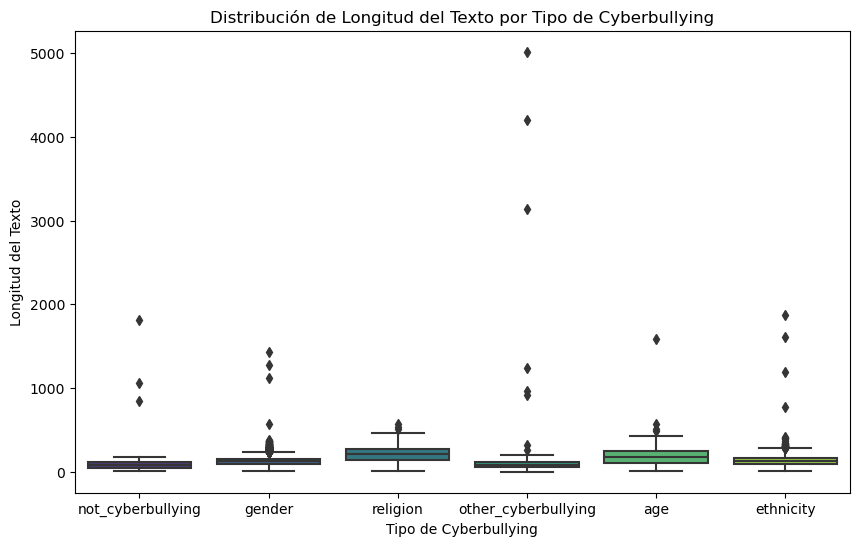

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_raw, x='cyberbullying_type', y='text_length' , palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Longitud del Texto')
plt.title('Distribución de Longitud del Texto por Tipo de Cyberbullying')
plt.show()

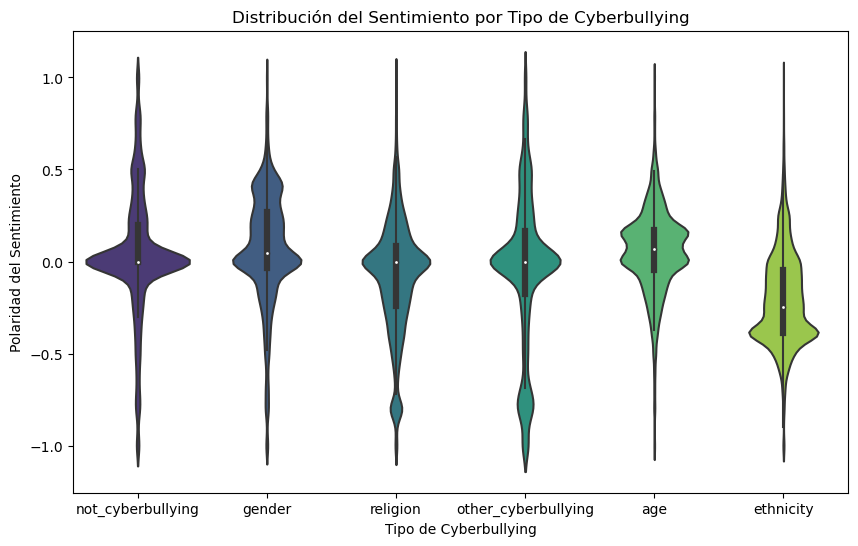

In [12]:
df_raw['sentiment'] = df_raw['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_raw, x='cyberbullying_type', y='sentiment', palette='viridis')
plt.xlabel('Tipo de Cyberbullying')
plt.ylabel('Polaridad del Sentimiento')
plt.title('Distribución del Sentimiento por Tipo de Cyberbullying')
plt.show()

In [13]:
df_raw

,tweet_text,cyberbullying_type,text_length,sentiment
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.000000
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.200000
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.150000
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.000000
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333


### Diccionario de mapeo de tipos de bullying (clases) a números


In [14]:
cyberbullying_classes = {
    "not_cyberbullying": 0,
    "gender": 1,
    "religion": 2,
    "other_cyberbullying": 3,
    "age": 4,
    "ethnicity": 5
}

df_raw['cyberbullying_numeric_type'] = df_raw['cyberbullying_type'].map(cyberbullying_classes)
df_raw.head()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying,61,-0.15625,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,115,0.00000,0
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,60,0.20000,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,103,0.15000,0
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,103,0.00000,0


In [15]:
df_raw.tail()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5
47688,Turner did not withhold his disappointment. Tu...,ethnicity,276,-0.300000,5
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,104,-0.387500,5
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,90,-0.458333,5
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,76,-0.058333,5


### Exploración de Relaciones

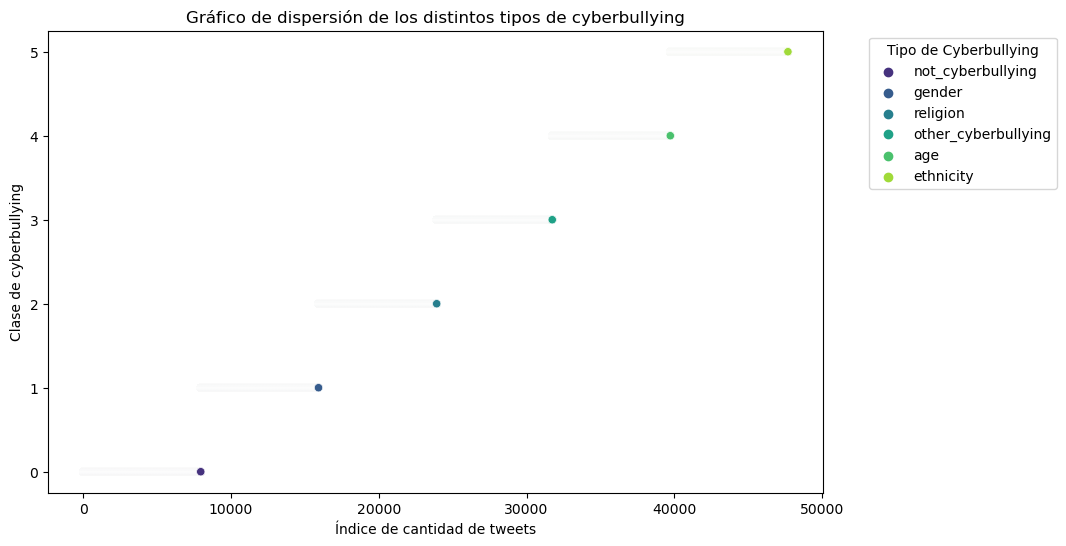

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=df_raw.index, y='cyberbullying_numeric_type', hue='cyberbullying_type', data=df_raw, palette='viridis')
# plt.title('Gráfico de dispersión de los distintos tipos de cyberbullying')
# plt.xlabel('Índice de cantidad de tweets')
# plt.ylabel('Clase de cyberbullying')
# plt.legend(title='Tipo de Cyberbullying', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


Hay que seguir investigando la naturaleza de la variable other_cyberbullying y entender si es posible utilizarla como regresora también, al igual que age, religion, ethnicity.

In [17]:
def preprocess_column(column):
    column = column.str.lower() # convertir los tweets a minuscula.
    return column

df_raw['tweet_text'] = preprocess_column(df_raw['tweet_text'])
df_raw.head()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,-0.15625,0
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,0.00000,0
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,0.20000,0
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,0.15000,0
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,0.00000,0


In [18]:
nltk.download('punkt')
nltk.download('stopwords')

# Define la función clean_tweet
def clean_tweet(tweet:str) -> str:
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) # Remove urls
    tweet = re.sub(r'@[A-Za-z0-9]+','', tweet) # Remove @mentions
    tweet = re.sub(r'\#[A-Za-z0-9]+','', tweet) # Remove hashtags
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet) # Remove special characters and punctuation
    tweet = tweet.lower() # Convert to lowercase

    tokens = word_tokenize(tweet) # Tokenize

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    clean_tweet = ' '.join(filtered_tokens) # Join tokens back into string

    return clean_tweet


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noeliaqualindi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Se aplica la función clean_tweet a la columna 'tweet_text' y limpiamos los tweets de urls y caracteres especiales


In [19]:
df_raw['clean_tweet'] = df_raw['tweet_text'].apply(clean_tweet)

# mostramos los primeros registros del dataframe limpio
df_raw.head()

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,-0.15625,0,words food crapilicious
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,0.00000,0,white
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,0.20000,0,classy whore red velvet cupcakes
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,0.15000,0,gio meh p thanks heads concerned another angry...
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,0.00000,0,isis account pretending kurdish account like i...


### Contabilización de palabras

In [20]:
def count_words(df: pd.DataFrame, cyberbullying_type : str = None):
    if cyberbullying_type is None:
        df_count = df
    else:
        df_count = df[df['cyberbullying_type'] == cyberbullying_type]

    text = ' '.join(df_count['clean_tweet'])
    words = text.split()
    word_counts = Counter(words)

    return word_counts

In [21]:
count_words(df_raw)

Counter({'school': 8711,
         'like': 5867,
         'fuck': 5800,
         'dumb': 5330,
         'high': 5096,
         'people': 4812,
         'bullied': 4664,
         'im': 4497,
         'dont': 4407,
         'nigger': 4301,
         'rt': 4292,
         'rape': 4223,
         'u': 4112,
         'gay': 3971,
         'bully': 3586,
         'jokes': 3462,
         'one': 3404,
         'get': 2846,
         'girls': 2833,
         'ass': 2797,
         'girl': 2710,
         'black': 2695,
         'amp': 2608,
         'muslims': 2403,
         'know': 2342,
         'muslim': 2324,
         'white': 2187,
         'think': 2130,
         'would': 2055,
         'joke': 2031,
         'bitch': 2025,
         'idiot': 1983,
         'got': 1878,
         'right': 1836,
         'say': 1744,
         'fucking': 1677,
         'call': 1676,
         'even': 1657,
         'bullies': 1647,
         'go': 1639,
         'women': 1623,
         'cant': 1618,
         'make': 16

In [22]:
def words_bar_charts(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    num_classes = len(cyberbullying_classes)


    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharey=True)

    axes = axes.ravel()

    viridis_colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

    for i, (ax, (cyberbullying_type, value)) in enumerate(zip(axes, cyberbullying_classes.items())):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())
        words = text.split()
        word_counts = Counter(words)
        top_words = word_counts.most_common(20)
        words, counts = zip(*top_words)

        ax.bar(words, counts, color=viridis_colors[i])
        ax.set_title(f'Top 20 palabras en tweets de tipo "{cyberbullying_type}"')
        ax.set_xlabel('Palabra')
        ax.set_ylabel('Cantidad')
        ax.tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


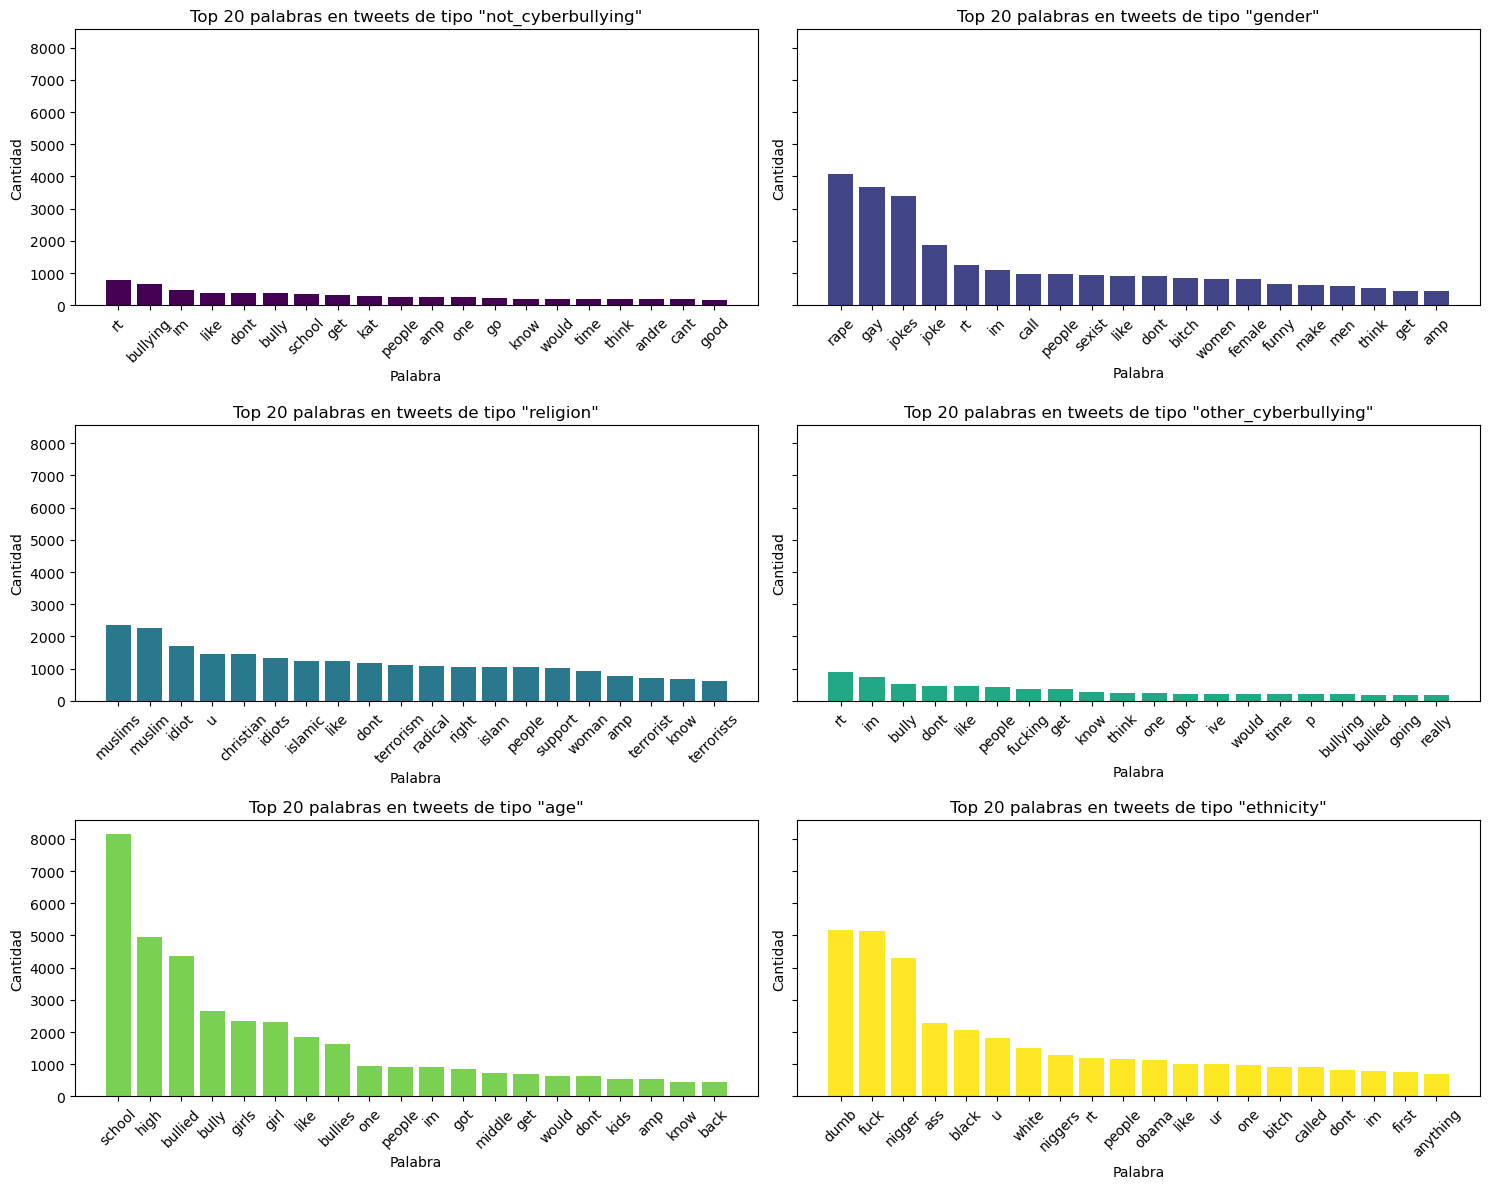

In [23]:
words_bar_charts(df_raw, cyberbullying_classes)

In [52]:
def wordcloud_subplots(dataframe: pd.DataFrame, cyberbullying_classes: dict):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

    axes = axes.ravel()

    for ax, (cyberbullying_type, value) in zip(axes, cyberbullying_classes.items()):
        df_filter = dataframe[dataframe['cyberbullying_numeric_type'] == value]

        text = ' '.join(df_filter['clean_tweet'].to_list())

        wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Nube de palabras para "{cyberbullying_type}"')
        ax.axis('off')

    for i in range(len(cyberbullying_classes), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

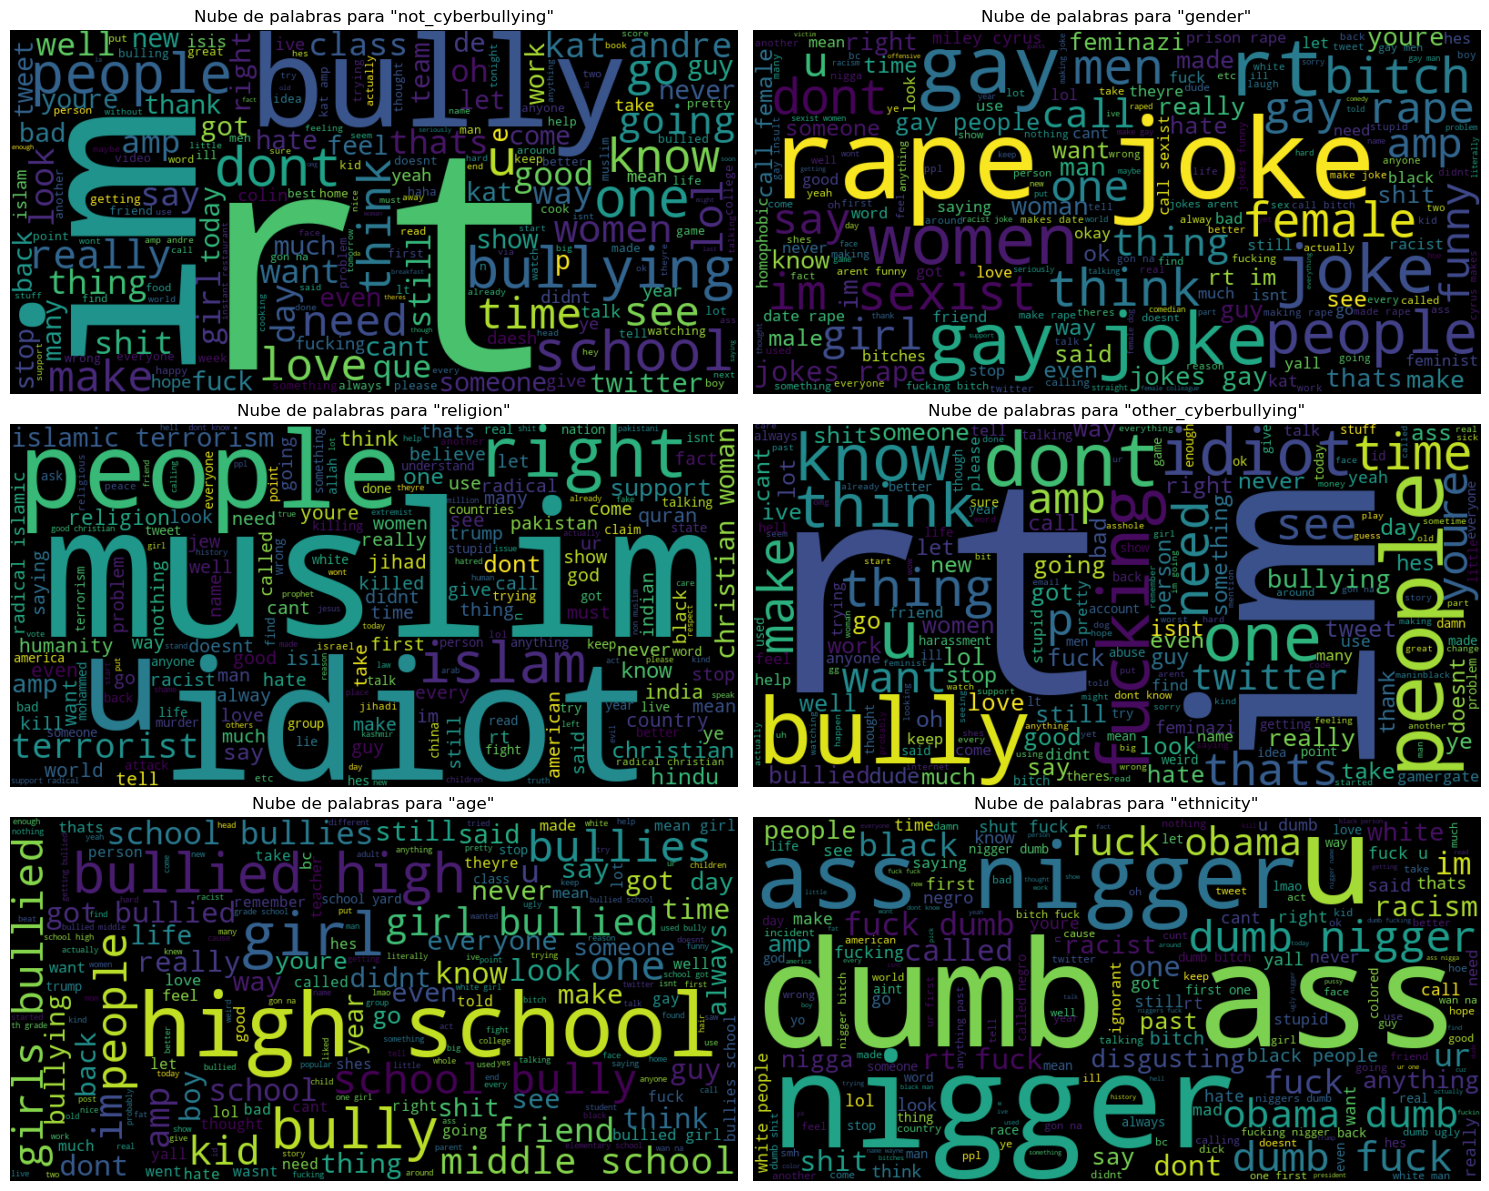

In [53]:
wordcloud_subplots(df_raw, cyberbullying_classes)

### Tokenizacion y Lemmatización

In [26]:
nlp = spacy.load("en_core_web_sm")
df_raw['tokens'] = df_raw['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_raw

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet,tokens
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250,0,words food crapilicious,"[words, food, crapilicious]"
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,0.000000,0,white,[white]
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,0.200000,0,classy whore red velvet cupcakes,"[classy, whore, red, velvet, cupcakes]"
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,0.150000,0,gio meh p thanks heads concerned another angry...,"[gio, meh, p, thanks, heads, concerned, anothe..."
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,0.000000,0,isis account pretending kurdish account like i...,"[isis, account, pretending, kurdish, account, ..."
...,...,...,...,...,...,...,...
47687,"black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5,black ppl arent expected anything depended any...,"[black, ppl, are, nt, expected, anything, depe..."
47688,turner did not withhold his disappointment. tu...,ethnicity,276,-0.300000,5,turner withhold disappointment turner called c...,"[turner, withhold, disappointment, turner, cal..."
47689,i swear to god. this dumb nigger bitch. i have...,ethnicity,104,-0.387500,5,swear god dumb nigger bitch got bleach hair re...,"[swear, god, dumb, nigger, bitch, got, bleach,..."
47690,yea fuck you rt @therealexel: if youre a nigge...,ethnicity,90,-0.458333,5,yea fuck rt youre nigger fucking unfollow fuck...,"[yea, fuck, rt, you, re, nigger, fucking, unfo..."


In [27]:
def lemmatize_text(text):
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc]
  return lemmas


In [28]:
df_raw['lemas'] = df_raw['clean_tweet'].apply(lemmatize_text)
df_raw

,tweet_text,cyberbullying_type,text_length,sentiment,cyberbullying_numeric_type,clean_tweet,tokens,lemas
0,"in other words #katandandre, your food was cra...",not_cyberbullying,61,-0.156250,0,words food crapilicious,"[words, food, crapilicious]","[word, food, crapilicious]"
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,115,0.000000,0,white,[white],[white]
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,60,0.200000,0,classy whore red velvet cupcakes,"[classy, whore, red, velvet, cupcakes]","[classy, whore, red, velvet, cupcake]"
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,103,0.150000,0,gio meh p thanks heads concerned another angry...,"[gio, meh, p, thanks, heads, concerned, anothe...","[gio, meh, p, thank, head, concern, another, a..."
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,103,0.000000,0,isis account pretending kurdish account like i...,"[isis, account, pretending, kurdish, account, ...","[isis, account, pretend, kurdish, account, lik..."
...,...,...,...,...,...,...,...,...
47687,"black ppl aren't expected to do anything, depe...",ethnicity,234,0.011905,5,black ppl arent expected anything depended any...,"[black, ppl, are, nt, expected, anything, depe...","[black, ppl, be, not, expect, anything, depend..."
47688,turner did not withhold his disappointment. tu...,ethnicity,276,-0.300000,5,turner withhold disappointment turner called c...,"[turner, withhold, disappointment, turner, cal...","[turner, withhold, disappointment, turner, cal..."
47689,i swear to god. this dumb nigger bitch. i have...,ethnicity,104,-0.387500,5,swear god dumb nigger bitch got bleach hair re...,"[swear, god, dumb, nigger, bitch, got, bleach,...","[swear, god, dumb, nigger, bitch, get, bleach,..."
47690,yea fuck you rt @therealexel: if youre a nigge...,ethnicity,90,-0.458333,5,yea fuck rt youre nigger fucking unfollow fuck...,"[yea, fuck, rt, you, re, nigger, fucking, unfo...","[yea, fuck, rt, you, re, nigger, fucking, unfo..."


## Análisis y tratamiento de Outliers

In [33]:
# Función para extraer estadísticas de un tweet
def analyze_tweet(text):
    doc = nlp(text)
    num_tokens = len(doc)
    num_words = len([token for token in doc if token.is_alpha])
    num_chars = len(text)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_punctuations = len([token for token in doc if token.is_punct])
    num_nouns = len([token for token in doc if token.pos_ == "NOUN"])
    num_verbs = len([token for token in doc if token.pos_ == "VERB"])
    
    return {
        'num_tokens': num_tokens,
        'num_words': num_words,
        'num_chars': num_chars,
        'num_stopwords': num_stopwords,
        'num_punctuations': num_punctuations,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs
    }

# Aplicar la función a cada tweet en el DataFrame
stats = df_raw['clean_tweet'].apply(analyze_tweet)

# Convertir la lista de diccionarios en un DataFrame
stats_df = pd.DataFrame(list(stats))

# Añadir las estadísticas al DataFrame original
for column in stats_df.columns:
    df_raw[column] = stats_df[column]

# Añadir tokenización y lematización
df_raw['tokens'] = df_raw['clean_tweet'].apply(lambda text: [token.text for token in nlp(text)])
df_raw['lemmas'] = df_raw['clean_tweet'].apply(lambda text: [token.lemma_ for token in nlp(text)])

# Función para detectar outliers usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detectar outliers en las columnas numéricas
outliers_num_tokens, lb_tokens, ub_tokens = detect_outliers(df_raw, 'num_tokens')
outliers_num_words, lb_words, ub_words = detect_outliers(df_raw, 'num_words')
outliers_num_chars, lb_chars, ub_chars = detect_outliers(df_raw, 'num_chars')

# Mostrar tablas de outliers
print("Outliers en num_tokens:\n", outliers_num_tokens)
print("Outliers en num_words:\n", outliers_num_words)
print("Outliers en num_chars:\n", outliers_num_chars)


Outliers en num_tokens:
                                               tweet_text cyberbullying_type  \
1317   @eurekalertaaas: researchers push to import to...  not_cyberbullying   
3030   he embellished the afternoon with moustachioed...  not_cyberbullying   
4846   @andrea_gcav: @viviaanajim recuerdas como noso...  not_cyberbullying   
8062   is just so so creepy. if i joke about way less...             gender   
8111   y’all: “haha drunk pussy the best pussy” “when...             gender   
...                                                  ...                ...   
46169  @wizcrdwheezes hihihi ily from the bottom of m...          ethnicity   
46764  hi queen! first of all im rlly happy to be moo...          ethnicity   
47037  @purely_ambition: sooo mad. rt @tracepeterson ...          ethnicity   
47195  keeth i stg. he literally struggles to stream ...          ethnicity   
47619  vice was abt interviews, which explained y tra...          ethnicity   

       text_length  sentim

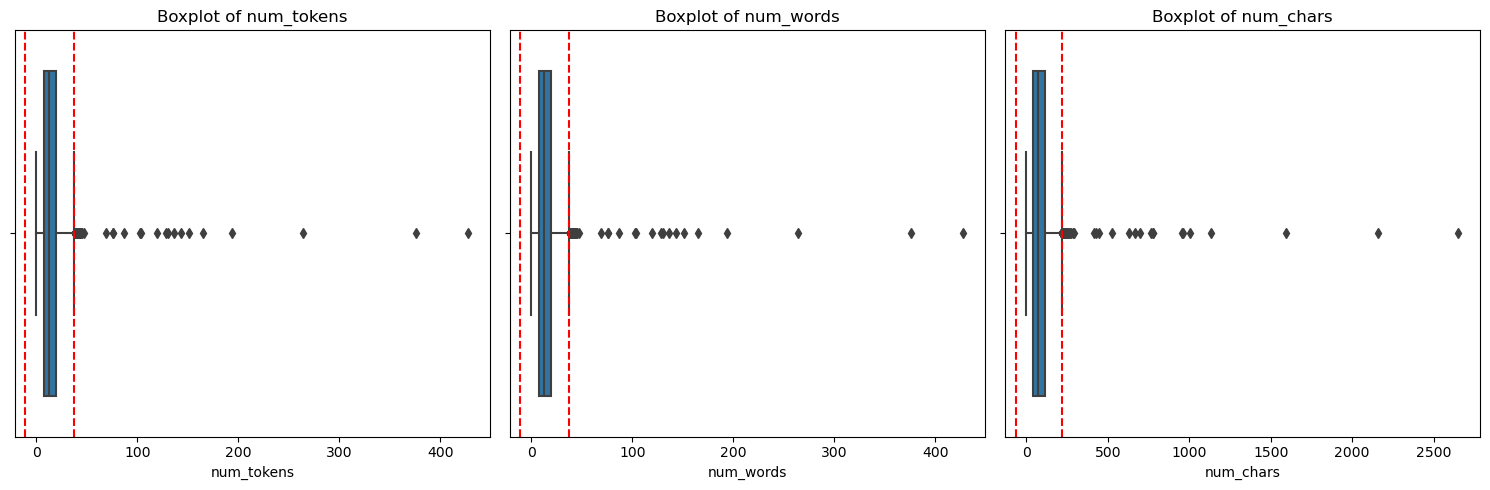

In [34]:
# Visualización de outliers usando gráficos de caja
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x=df_raw['num_tokens'])
plt.axvline(lb_tokens, color='r', linestyle='--')
plt.axvline(ub_tokens, color='r', linestyle='--')
plt.title('Boxplot of num_tokens')

plt.subplot(1, 3, 2)
sns.boxplot(x=df_raw['num_words'])
plt.axvline(lb_words, color='r', linestyle='--')
plt.axvline(ub_words, color='r', linestyle='--')
plt.title('Boxplot of num_words')

plt.subplot(1, 3, 3)
sns.boxplot(x=df_raw['num_chars'])
plt.axvline(lb_chars, color='r', linestyle='--')
plt.axvline(ub_chars, color='r', linestyle='--')
plt.title('Boxplot of num_chars')

plt.tight_layout()
plt.show()

In [46]:
df_raw.describe()

,text_length,sentiment,cyberbullying_numeric_type,num_tokens,num_words,num_chars,num_stopwords,num_punctuations,num_nouns,num_verbs
count,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.000000,47692.0,47692.000000,47692.000000
mean,136.253229,-0.027226,2.499602,13.502726,13.502726,82.618846,1.811897,0.0,4.518934,2.878177
std,85.226899,0.324770,1.708993,8.906400,8.906400,56.677589,1.979130,0.0,3.376061,2.319892
min,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,78.000000,-0.192857,1.000000,7.000000,7.000000,43.000000,0.000000,0.0,2.000000,1.000000
50%,124.000000,0.000000,2.000000,12.000000,12.000000,70.000000,1.000000,0.0,4.000000,2.000000
75%,180.000000,0.158688,4.000000,19.000000,19.000000,114.000000,3.000000,0.0,6.000000,4.000000
max,5018.000000,1.000000,5.000000,428.000000,428.000000,2652.000000,71.000000,0.0,142.000000,91.000000


In [70]:
num_null_tweets = df_raw['tweet_text'].isnull().sum()

print("Cantidad de tweets con valores nulos en 'tweet_text':", num_null_tweets)

Cantidad de tweets con valores nulos en 'tweet_text': 0


#### Cantidad de tweets de 1 sola palabra

In [69]:
df_raw['word_count'] = df_raw['tweet_text'].apply(lambda x: len(str(x).split()))

# Filtrar los tweets que tienen solo una palabra
single_word_tweets = df_raw[df_raw['word_count'] == 1]

# Mostrar la cantidad de estos outliers
num_single_word_tweets = single_word_tweets.shape[0]

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
print("Cantidad de tweets de una sola palabra (outliers semánticos a analizar):", num_single_word_tweets)
print("Tweets de una sola palabra:\n", single_word_tweets[['clean_tweet']])

Cantidad de tweets de una sola palabra (outliers semánticos a analizar): 204
Tweets de una sola palabra:
                                             clean_tweet
173                                                    
307                                                    
314                                           preseason
334                                                 ffs
795                                                    
853                                               rtvid
921                                                    
1136                                                   
1369                                                   
1385                                           hahahaha
1409                                                   
1422                                                   
1513                                                   
1702                                              laura
1839                                                  